Universal Quantification (Forall)
==================

Universal quantification is another core concept in **Prove-It**.  A `Forall` operation, formatted with the $\forall$ symbol, is used to represent universal quantification.  For example, $\forall_x P(x)$ means that $P(x)$ is true for any instance of $x$.  $P(x)$ holds true universally over instances of $x$.  Like `Implies`, `Forall` is a core concept that is aliased at the top proveit level but is defined outside of the core in the `proveit.logic` package. It is known in the core for use in the *specialization* and *generalization* derivation steps discussed below.  First, let us example the `Forall` class

In [1]:
# Let us create a basic Forall expression and examine it
from proveit import Forall
from proveit.common import x, P, Px, Q, Qx, R, Rx, S
basicForallExpr = Forall(x, Px, conditions=[Qx, Rx], domain=S)
basicForallExpr

The meaning of this **Expression** is that $P(x)$ is a true statement for all instances of $x$ for which $x \in S$ and $Q(x)$ is true.  Let us examine the internal structure of this expression.

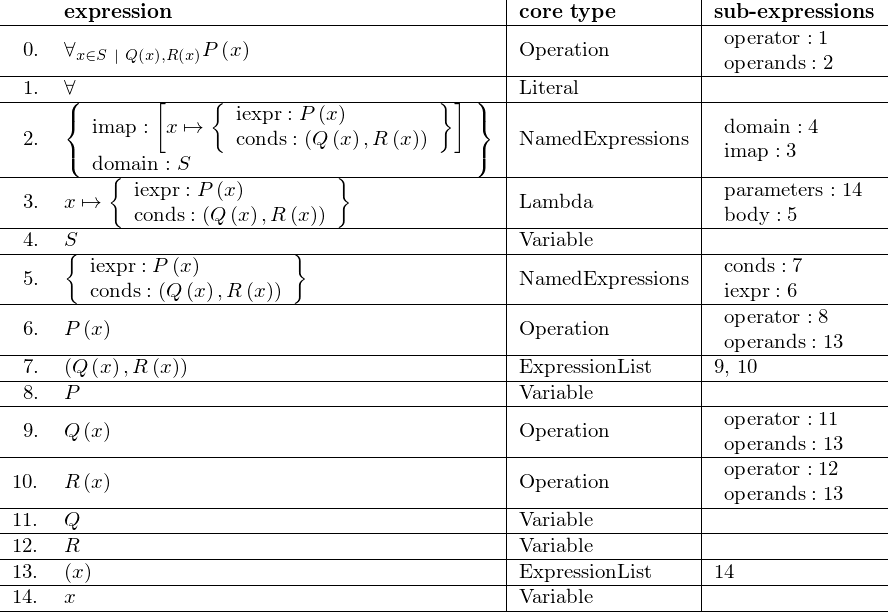

In [2]:
basicForallExpr.exprInfo()

`Forall` derives from `OperationOverInstances` (`proveit._generic_.operation_over_instances.OperationOverInstances` aliased as `proveit.OperationOverInstances`) which defines the **NamedExpression** structures with `domain`, `imap` (short for "instance mapping"), `conds` (short for "conditions"), and `iexpr` (short for "instance expression") sub-**Expression** roles.  This is a useful structure for all of the `OperationOverInstances` type of expressions ($\exists$, $\sum$, $\prod$, etc., as well as $\forall$).  In our example above, `imap` defines the universal quantification instances using a **Lambda** map, mapping $x$ (the "instance variable") to the `iexpr`, $P(x)$, as well as $x$-dependent `conditions`, $(Q(x), R(x))$.  The  `domain` over which $x$ is being quantified is $S$.  Each of these `Forall` parts may be accessed as follows:

In [3]:
basicForallExpr.instanceVars # list of Variables

[x]

In [4]:
basicForallExpr.instanceExpr

In [5]:
basicForallExpr.conditions

In [6]:
basicForallExpr.domain

Specialization
======

The *specialization* derivation step uses *expression substitution* internally.  The difference is that *specialization* has proof implications and enforces the extra restrictions to justify these proof implications.  It also eliminates one or more of the outer $\forall$ operations.


### Basic Specialization

Let us take our basic/generic example of the `Forall` expression above and specialize it with a particular "instance" expression.  To do so, we will make assumptions to trivially allow this derivation step to be taken (just to show how this works).

In [7]:
from proveit import Operation, InSet, ExpressionList
from proveit.common import fy
assumptions = ExpressionList(basicForallExpr, InSet(fy, S), Operation(Q, fy), Operation(R, fy))
assumptions

`InSet` is another core concept that is defined outside of the core in `proveit.logic`.  It represents the set membership operation using the $\in$ symbol.  It is needed as a core concept specifically for the purpose of ensuring that universal quantification requirements are met (the "instance" expression must be "in" the domain set).

In [8]:
stmt = basicForallExpr.specialize({x:fy}, assumptions=assumptions)
stmt

We have proven, somewhat trivially, that $P(f(y))$ is true assuming that $\forall_{x \in S~|~Q(x)} P(x)$, $f(y) \in S$, $Q(f(y))$ are all true statements.  Let is take a look at the proof for this statement.

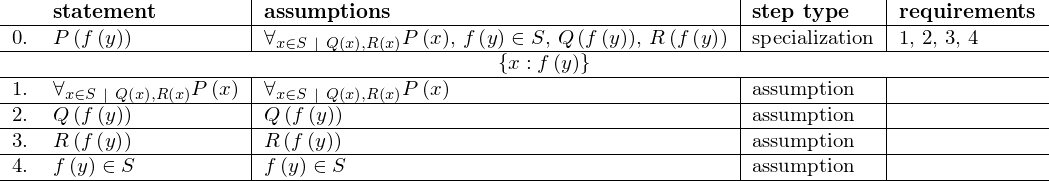

In [9]:
stmt.proof()

This indicates that the proof requires a *specialization* step and explicitly indicates the mapping being performed (taking $x$ to $f(y)$).  The subsequent proof steps that are required are simply proofs by assumption.  Specifically, the original `Forall` expression must be true, the "instance" expression must be in the domain $S$, and the condition $Q(x)$ must apply when $x$ is replaced with the "instance" expression.  If any of these are not known to be true under the provided assumptions, this step will fail.

In this first case, it is unable to prove the original `Forall` expression even after attempting to perform automation.

In [10]:
from proveit import ProofFailure
try:
    basicForallExpr.specialize({x:fy}, assumptions=assumptions[1:])
except ProofFailure as e:
    print "EXPECTED ERROR:", e

EXPECTED ERROR: Unable to prove forall_{x in S | Q(x),R(x)} P(x) assuming {f(y) in S, Q(f(y)), R(f(y))}: Unable to conclude automatically; the domain has no 'foldAsForall' method.


The automation checks to see of the $S$ **Expression** has a `foldAsForall` method that would automate a proof for universal quantification over $S$.  Since $S$ is a simple **Variable** object, no such automation exists.  Next we'll see what happens when there the "instance" expression is not in the $S$ domain.

In [11]:
from proveit import SpecializationFailure
try:
    basicForallExpr.specialize({x:fy}, assumptions=assumptions[:1]+assumptions[2:])
except SpecializationFailure as e:
    print "EXPECTED ERROR:", e

EXPECTED ERROR: Unable to prove P(f(y)) assuming {forall_{x in S | Q(x),R(x)} P(x), Q(f(y)), R(f(y))}: Unmet specialization condition: f(y) in S


Finally, we demonstrate the case when one of the conditions is not met.

In [12]:
try:
    basicForallExpr.specialize({x:fy}, assumptions=assumptions[:2]+assumptions[3:])
except SpecializationFailure as e:
    print "EXPECTED ERROR:", e

EXPECTED ERROR: Unable to prove P(f(y)) assuming {forall_{x in S | Q(x),R(x)} P(x), f(y) in S, R(f(y))}: Unmet specialization condition: Q(f(y))


In [13]:
try:
    basicForallExpr.specialize({x:fy}, assumptions=assumptions[:3])
except SpecializationFailure as e:
    print "EXPECTED ERROR:", e

EXPECTED ERROR: Unable to prove P(f(y)) assuming {forall_{x in S | Q(x),R(x)} P(x), f(y) in S, Q(f(y))}: Unmet specialization condition: R(f(y))


Also note that you cannot *specialize* a variable that is not one of the `Forall` instance variables.

In [14]:
basicForallExpr

In [15]:
try:
    basicForallExpr.specialize({x:fy, Q:R}, assumptions=assumptions)
except SpecializationFailure as e:
    print "EXPECTED ERROR:", e

EXPECTED ERROR: Proof step failed assuming {forall_{x in S | Q(x),R(x)} P(x), f(y) in S, Q(f(y)), R(f(y)), forall_{x in S | Q(x),R(x)} P(x)}: May only specialize instance variables of directly nested Forall operations


You can *relabel* **Variable**s that are not `Forall` instance variables.  Later we will show that you can *relabel* and *specialize* simultaneously.  You can also *specialize* multiple levels of `Forall` operations simultaneously which is why the previous error message mentions "nested Forall operations". 

### Universal quantification without a domain

It is not necessary to specify a domain in a `Forall` **Expression**.  For example, the condition(s) may provide sufficient restrictions for the universal quantification.  Also, any number of conditions may be specified (including no conditions).

In [16]:
noDomainForallExpr = Forall(x, Px, conditions=[Qx])
noDomainForallExpr

In [17]:
print noDomainForallExpr.domain

None


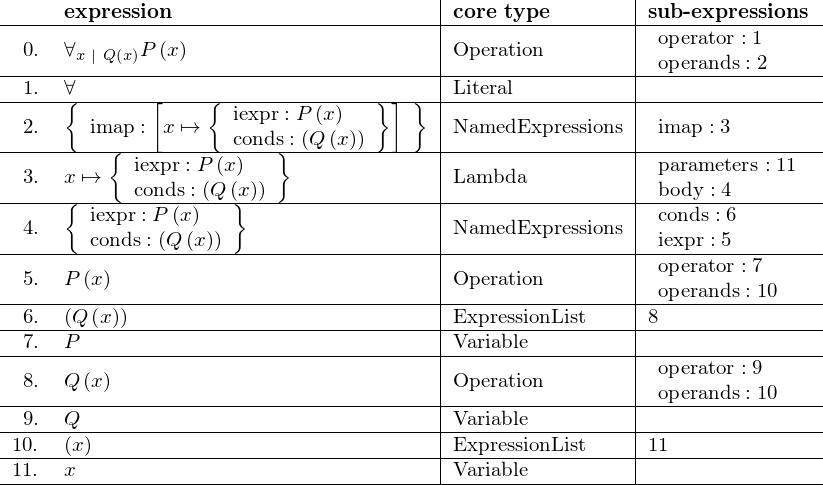

In [18]:
noDomainForallExpr.exprInfo()

In [19]:
noDomainForallExpr.specialize({x:fy}, assumptions=[noDomainForallExpr, Operation(Q, fy)])

### Lambda scope restrictions

In `tutorial01_core_expr`, we noted scoping restrictions that apply to **Lambda** expressions in the context of *expression substitution*.  That restriction carries over to *specialization* and is very important.  Consider the following example.

In [20]:
from proveit.common import Pxy, y, fy
from proveit.logic import Exists, NotEquals
forallExistsExpr = Forall(x, Exists(y, NotEquals(x, y)))
forallExistsExpr

We are using `Exists` ($\exists$) and `Equals` ($\neq$) which do not have the special core status that `Forall` has and are discussed in `logic` package tutorials.  We are just using them to make our point below more clear.  Just note that `Exists` has the same kind of structure as $\forall$ and specifically acts as an **Operation** on an **Expression** with a **Lambda** function.

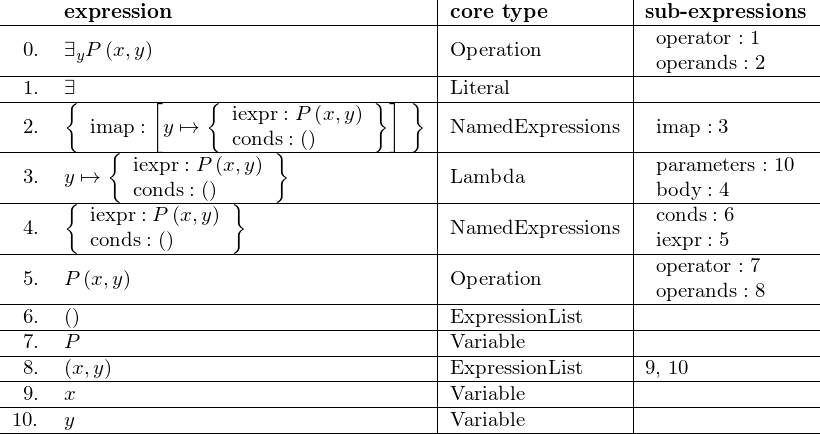

In [21]:
Exists(y, Pxy).exprInfo()

If we try to specialize $x$ as $y$ in `nestedForall`, this will fail:

In [22]:
from proveit import ScopingViolation
try:
    forallExistsExpr.specialize({x:y}, assumptions={forallExistsExpr})
except ScopingViolation as e:
    print "EXPECTED ERROR:", e

EXPECTED ERROR: Must not make substitution with reserved variables  (i.e., parameters of a Lambda function)


This should fail.  We cannot derive $\exists_y y \neq y$ by assuming $\forall_{ x } \left[\exists_y x \neq y \right]$.  The former is a stronger statement.  We chose this example, in fact, because the latter can be argued as typically true but the former is never true using reasonable definitions.  Where this goes wrong is in violating the scope of $\exists_y$.  It is introducing $y$ as a new **Variable** within the sub-expression $\exists_y x \neq y$.  This label is off limits to $x$ which is quantified outside of this sub-expression.  We can specialize $x$ to whatever we want as long as we respect these scoping restrictions.  It is not simply $y$ that is off limits; all expressions involving $y$ are off limits:

In [23]:
from proveit import ScopingViolation
try:
    forallExistsExpr.specialize({x:fy}, assumptions={forallExistsExpr})
except ScopingViolation as e:
    print "EXPECTED ERROR:", e

EXPECTED ERROR: Must not make substitution with reserved variables  (i.e., parameters of a Lambda function)


It should also be noted that within a scope, a **Variable** may be reused with a different meaning.  This should generally be avoided as it makes **Expression**s unclear, but the functionality should be well-defined in case it ever happens.  If this happens, we treat it as a distinct **Variable** from anything outside of the scope (that just happens to have the same name).  It can be confusing and should be avoided, but it is well-defined.  For example,

In [24]:
from proveit.logic import And
redundantInstanceVarExpr = Forall(x, And(Px, Forall(x, Qx)))
redundantInstanceVarExpr

In [25]:
# specializing the outer x does not and should not change the inner x which is treated as a distinct Variable
redundantInstanceVarExpr.specialize({x:fy}, assumptions={redundantInstanceVarExpr})

### Operand, operator, or operation specialization

*Specializing* different parts of an **Operation** works essentially the same way as it does with *expression substition*.

We will use the `substitution` axiom of `proveit.logic.equality` for demonstrations in this section out of convenience.  Axioms and the `proveit.logic` package will be discussed in more detail later.  For now, we note that axioms (and theorems) are taken to be true statements without proof as you can see below.

In [26]:
from proveit.logic.equality._axioms_ import substitution
substitution

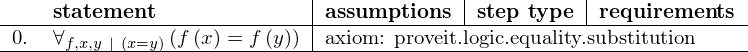

In [27]:
substitution.proof()

Let's grab the $x=y$ condition for use below.

In [28]:
x_eq_y = substitution.conditions[0]
x_eq_y

Operator and operand *specialization* is straightforward:

In [29]:
from proveit.common import f, g
operatorSubstitution = substitution.specialize({f:g}, assumptions=[x_eq_y])
operatorSubstitution

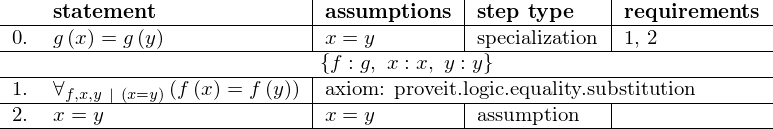

In [30]:
operatorSubstitution.proof()

Note that $x$ and $y$ mapped to themselves by default.  When a mapping is not specified, the default is to map the **Variable** to itself.

In [31]:
from proveit.logic import Equals
from proveit.common import a, b
a_eq_b = Equals(a, b)
operandSubstitution = substitution.specialize({x:a, y:b}, assumptions=[a_eq_b])
operandSubstitution

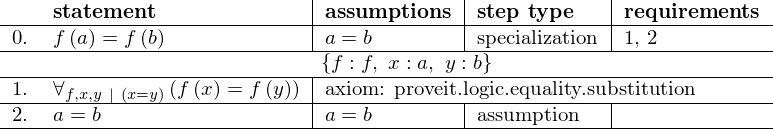

In [32]:
operandSubstitution.proof()

Operation substitution can be done explicitly via a **Lambda** expression just as we saw with *expression substitution*.  The **Lambda** expression is not literally substituted in; rather, the function that it represents is applied as the operation.

In [33]:
from proveit import Lambda
from proveit.number import Add
operationSubstitution = substitution.specialize({f:Lambda(x, Add(x, a))}, assumptions=[x_eq_y])
operationSubstitution

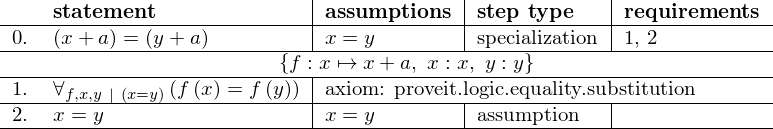

In [34]:
operationSubstitution.proof()

An alternative way to specify an operation substitution is to map the operation applied to a **Variable** onto an expression that uses this same **Variable**.  In this example, mapping $f(x)$ to $x + a$.  This will be internally translated to the same **Lambda** expression as before: $x \mapsto x + a$.

In [35]:
from proveit.common import fx
operationSubstitution2 = substitution.specialize({fx:Add(x, a)}, assumptions=[x_eq_y])
operationSubstitution2

The proof is exactly the same as before.

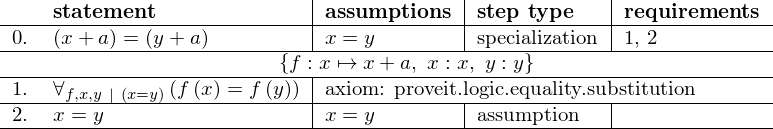

In [36]:
operationSubstitution2.proof()

### Specializing multiple levels simultaneously

When `Forall` operations are nested, the universal quantifications may be specialized separately.  For example:

In [37]:
from proveit.number import LessThan
from proveit.common import z, Pxyz
nestedForall = Forall(x, Forall(y, Forall(z, Pxyz, conditions=[LessThan(z, Add(x, y))])))
nestedForall

In [38]:
nestedForallSpec1 = nestedForall.specialize(assumptions=[nestedForall])
nestedForallSpec1

In [39]:
nestedForallSpec2 = nestedForallSpec1.specialize()
nestedForallSpec2

In [40]:
nestedForallSpec3 = nestedForallSpec2.specialize(assumptions=[nestedForallSpec2.conditions[0]])
nestedForallSpec3

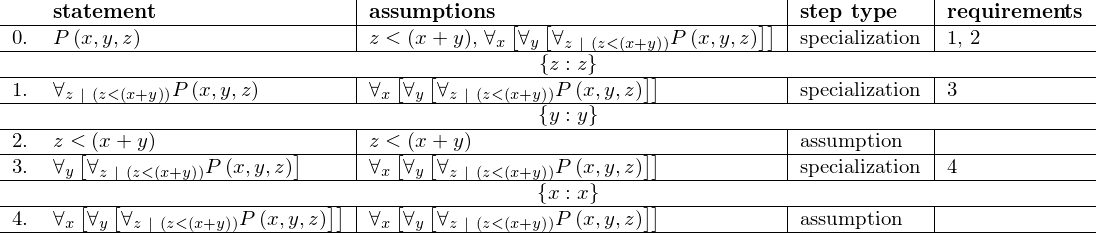

In [41]:
nestedForallSpec3.proof()

But for the sake of convenience and efficiency, **Prove-It** also allows nested `Forall` operations to be specialized simultaneously:

In [42]:
assumptions = ExpressionList(nestedForall, nestedForallSpec2.conditions[0])
nestedForallSimultaneousSpec = nestedForall.specialize({z:z}, assumptions=assumptions)
nestedForallSimultaneousSpec

We just need to include an explicit mapping for an inner quantified **Variable**.  So we indicated above that we want to map $z$ to $z$ even though this is typically the default in order to force it to specialize all three `Forall` operations simultaneously.  The proof is shorter, doing a single all-in-one *specialization*:

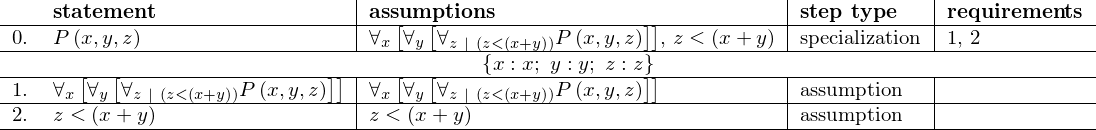

In [43]:
nestedForallSimultaneousSpec.proof()

In the mapping that is indicated below step 0, semicolons ';' are used to separate the mappings at different levels.  In this way, there can be no ambiguity.  Simultaneous *specialization* can be done for any number of nested levels.

### Specializing and relabeling simultaneously

It is also possible to *relabeling* and *specialization* (over any number of nested levels) in one step.  For example: 

In [44]:
nestedForallSpecAndRelab = nestedForall.specialize(specializeMap={y:y}, relabelMap={z:a}, assumptions=[nestedForall])
nestedForallSpecAndRelab

The `relabelMap` is specified separately from the `specializeMap` to be unambiguous.

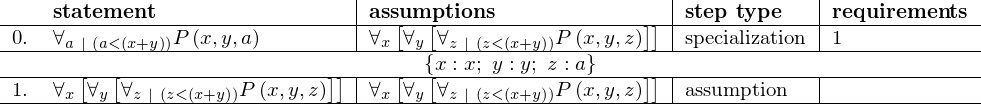

In [45]:
nestedForallSpecAndRelab.proof()

The *relabeling* map is always shown after the last semicolon ';' in the *specialization* map.  When any *specialization* occurs, the "step type" is labeled "specialization".  If there is only *relabeling*, the "step type" is labeled "relabeling". 

You are not allowed to specify that the same **Variable** is to be *specialized* and *relabeled*.

In [46]:
from proveit import RelabelingFailure
try:
    nestedForall.specialize({y:y}, {y:a}, assumptions=assumptions)
except RelabelingFailure as e:
    print "EXPECTED ERROR:", e

EXPECTED ERROR: Proof step failed assuming {forall_{x} [forall_{y} [forall_{z | (z < (x + y))} P(x,y,z)]], z < (x + y)}: Cannot relabel using assumptions that involve any of the relabeling variables


As noted in the previous tutorial, relabeling has another important limitation.  You cannot relabel something using assumptions that involve any of the relabeling variables.  For example, we cannot relabel $P$ to $R$ in `nestedForall` while assuming `nestedForall`.  

In [47]:
from proveit import RelabelingFailure
try:
    nestedForall.specialize({y:y}, {P:R}, assumptions=assumptions)
except RelabelingFailure as e:
    print "EXPECTED ERROR:", e

EXPECTED ERROR: Proof step failed assuming {forall_{x} [forall_{y} [forall_{z | (z < (x + y))} P(x,y,z)]], z < (x + y)}: Cannot relabel using assumptions that involve any of the relabeling variables


### Universal quantification over multiple variables

In [48]:
multiVarForall = Forall((x, y), Pxy, domain=S)
multiVarForall

In [49]:
multiVarForall.specialize(assumptions=[multiVarForall, InSet(x, S), InSet(y, S)])

In [50]:
try:
    Forall((x, x), Px)
except ValueError as e:
    print 'EXPECTED ERROR:', e

EXPECTED ERROR: Lambda parameters Variables must be unique with respect to each other.


### Universal quantifaction over an unspecified number of variables

Generalization
========